In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install diffusers transformers accelerate safetensors
!pip install pillow
%pip install kagglehub
%pip install opencv-python


Looking in indexes: https://download.pytorch.org/whl/cu121



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
"""
import kagglehub

# Download latest version
path = kagglehub.dataset_download("klemenko/kitti-dataset")

print("Path to dataset files:", path)
"""
path = r'C:\Users\yuval\.cache\kagglehub\datasets\klemenko\kitti-dataset\versions\1'

Total images: 7481


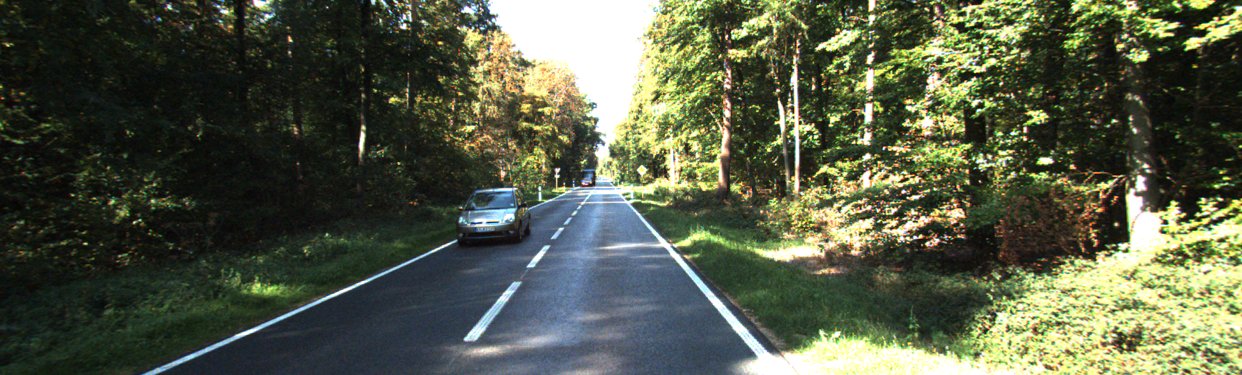

In [5]:
from glob import glob
from PIL import Image

img_dir = f"{path}/data_object_image_2/training/image_2"

images = sorted(glob(f"{img_dir}/*.png"))

print("Total images:", len(images))
img = Image.open(images[13])
img

In [4]:
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
).to("cuda")
pipe.safety_checker = None
pipe.enable_attention_slicing()

C:\Users\yuval\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


In [70]:
import numpy as np
def white_to_alpha(img, threshold=240):
      img = img.convert("RGBA")
      data = np.array(img)

      r, g, b, a = data.T
      white = (r > threshold) & (g > threshold) & (b > threshold)

      data[..., 3][white] = 0

      return Image.fromarray(data)

def generate_textures(prompt, negative, amount, path, start_from=0):
  for i in range(start_from, start_from+amount):
    gen_texture = pipe(
    prompt=prompt,
    negative_prompt=negative,
    height=512,
    width=512,
    guidance_scale=7
    ).images[0]
    gen_texture.save("gen_texture_raw.png")
    gen_texture = white_to_alpha(gen_texture)
    gen_texture.save(f"{path}/gen_texture{i}.png")


prompt = open(r'mud/prompts/prompt', 'r', encoding='utf-8').read()
negative = open(r'mud/prompts/negative', 'r', encoding='utf-8').read()
generate_textures(prompt, negative, 5, 'mud', start_from=5)


100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


In [3]:
from PIL import Image, ImageDraw, ImageFilter
import numpy as np
import cv2

def generate_contamination_mask(size, contamination_level=3, min_r=6, max_r=16, blur=6, sub_circles_per_spot=10, sub_circle_radius_factor=0.2):
    w, h = size
    mask = Image.new("L", (w, h), 0)
    draw = ImageDraw.Draw(mask)

    for _ in range(contamination_level*100):
        main_r = np.random.randint(min_r, max_r)
        center_x = np.random.randint(main_r, w - main_r)
        center_y = np.random.randint(main_r, h - main_r)

        # Draw main blob with multiple smaller, randomly offset circles to create an irregular shape
        for _ in range(sub_circles_per_spot):
            # Random offset from the main center, within the main_r area
            offset_x = np.random.randint(-main_r, main_r)
            offset_y = np.random.randint(-main_r, main_r)

            # Ensure sub_circle_r is positive and varied
            sub_circle_r = max(1, int(main_r * sub_circle_radius_factor * np.random.uniform(0.5, 1.5)))

            # Calculate new center for the sub-circle
            sub_center_x = center_x + offset_x
            sub_center_y = center_y + offset_y

            # Clamp coordinates to stay within mask boundaries
            x1 = max(0, sub_center_x - sub_circle_r)
            y1 = max(0, sub_center_y - sub_circle_r)
            x2 = min(w, sub_center_x + sub_circle_r)
            y2 = min(h, sub_center_y + sub_circle_r)

            if x1 < x2 and y1 < y2: # Only draw if valid bounding box
                draw.ellipse((x1, y1, x2, y2), fill=255)

    # Apply blur to make edges natural
    mask = mask.filter(ImageFilter.GaussianBlur(blur))

    return mask

def apply_refined_soiling(clean_img, texture_img, contamination_level=7, alpha_strength=1.8, edge_softness=5):
    # 1. Generate the mask
    mask_raw = generate_contamination_mask(clean_img.size, contamination_level)
    mask_np = np.array(mask_raw).astype(float) / 255.0

    # 2. Apply Gaussian blur for edge softness
    if edge_softness > 0:
        kernel_size = edge_softness * 2 + 1
        mask_np = cv2.GaussianBlur(mask_np, (kernel_size, kernel_size), 0)

    # 3. Scale mask by alpha_strength
    mask_np = mask_np * alpha_strength
    mask_np = np.clip(mask_np, 0, 1)

    # 4. Prepare images
    I = np.array(clean_img).astype(float)

    # Handle RGBA texture: use only RGB
    texture_resized = texture_img.resize(clean_img.size)
    Is = np.array(texture_resized)
    if Is.shape[2] == 4:  # RGBA
        Is = Is[:, :, :3].astype(float)
    else:
        Is = Is.astype(float)

    # 5. Expand mask to 3 channels
    m = mask_np[:, :, np.newaxis]

    # 6. Blend images
    dirty_img = (1 - m) * I + m * Is

    return Image.fromarray(np.uint8(np.clip(dirty_img, 0, 255)))



In [6]:
import random
from pathlib import Path
def create_synthetic_data(imgs, amount, textures_path, output_dir):
    for i in range(amount+1):
        img = Image.open(imgs[i])
        textures = list(Path(textures_path).glob("*.png"))
        gen_texture = Image.open(random.choice(textures))
        contamination_level = random.randint(1, 5)
        alpha_strength=2
        edge_softness=5
        final = apply_refined_soiling(img, gen_texture, contamination_level, alpha_strength, edge_softness)
        final.save(f"{output_dir}/{i}.png", format="PNG")

water_path = r'water'
mud_path = r'mud'
out_dir = 'dirty_imgs/mud'
create_synthetic_data(images[50:], 50, mud_path, out_dir)
